In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import os

SETTING UP TRAINING DATA

In [3]:
staph_gc_private = pd.read_csv("/Users/nirushanbhag/Downloads/sandra_ML/sandraMLfinal/private_gc_matrix.csv")
private_acc2iso = pd.read_csv("/Users/nirushanbhag/Downloads/sandra_ML/sandraMLfinal/private_acc2isolation.txt", sep="\t", header=None)

In [4]:
private_acc2iso.columns = ['genome_name', 'Isolation_Source']
staph_gc_pa_merged_private = staph_gc_private.merge(private_acc2iso, on="genome_name")
staph_gc_pa_merged_private = staph_gc_pa_merged_private[staph_gc_pa_merged_private["Isolation_Source"] != "Oral"]
staph_gc_pa_merged_private["Isolation_Source"] = staph_gc_pa_merged_private["Isolation_Source"].replace({"Skin": 0, "Urine": 1, "Nasal": 2})
training = staph_gc_pa_merged_private

training

genome_name  GC_00000001  GC_00000002  GC_00000003  GC_00000004  \
0          N101            1            1            1            1   
1          N102            1            1            1            1   
2          N104            1            1            1            1   
3          N107            1            1            1            1   
4          N112            1            1            1            1   
..          ...          ...          ...          ...          ...   
109        U212            1            1            1            1   
110        U217            1            1            1            1   
111        U218            1            1            1            1   
112        U219            1            1            1            1   
113        U223            1            1            1            1   

     GC_00000005  GC_00000006  GC_00000007  GC_00000008  GC_00000009  ...  \
0              0            1            1            1            1  ...   
1              1            1            1            1            1  ...   
2              1            1            1            1            1  ...   
3              1            1            1            1            1  ...   
4              1            1            1            1            1  ...   
..           ...          ...          ...          ...          ...  ...   
109            1            1            1            1            1  ...   
110            0            1            1            1            1  ...   
111            1            1            1            1            1  ...   
112            1            1            1            1            1  ...   
113            1            1            1            1            1  ...   

     GC_00004867  GC_00004868  GC_00004869  GC_00004870  GC_00004871  \
0              0            0            0            0            0   
1              0            0            0            0            0   
2              0            0            0            0            0   
3              0            0            0            0            0   
4              0            0            0            0            0   
..           ...          ...          ...          ...          ...   
109            0            0            0            0            0   
110            0            0            0            0            0   
111            0            0            0            0            0   
112            0            0            0            0            0   
113            0            0            0            0            0   

     GC_00004872  GC_00004873  GC_00004874  GC_00004875  Isolation_Source  
0              0            0            0            0                 2  
1              0            0            0            0                 2  
2              0            0            0            0                 2  
3              0            0            0            1                 2  
4              0            0            0            0                 2  
..           ...          ...          ...          ...               ...  
109            0            0            0            0                 1  
110            0            0            0            0                 1  
111            0            0            0            0                 1  
112            0            0            0            0                 1  
113            0            0            0            0                 1  

[104 rows x 4877 columns]

SETTING UP TESTING DATA (PUBLICLY AVAILABLE DATA)

In [5]:
#using the additional layer file to get names
staph_gc_public = pd.read_csv("/Users/nirushanbhag/Downloads/sandra_ML/sandraMLfinal/public_gc_matrix.csv")
public_acc2iso = pd.read_csv("/Users/nirushanbhag/Downloads/sandra_ML/sandraMLfinal/public_acc2isolation.txt", sep="\t", header=None)
public_acc2iso.columns = ['genome_name', 'Isolation_Source']
staph_gc_pa_mergedpublic = staph_gc_public.merge(public_acc2iso, on="genome_name")
staph_gc_pa_mergedpublic["Isolation_Source"] = staph_gc_pa_mergedpublic["Isolation_Source"].replace({"Skin": 0, "Urine": 1, "Nasal": 2})
testing = staph_gc_pa_mergedpublic

testing

genome_name  GC_00000001  GC_00000002  GC_00000003  GC_00000004  \
0       ERR3336677            1            1            1            1   
1       ERR3336678            1            1            1            1   
2       ERR3336679            1            1            1            1   
3       ERR3336680            1            1            1            1   
4       ERR3336681            1            1            1            1   
..             ...          ...          ...          ...          ...   
103  GCA_040718005            1            1            1            1   
104  GCA_040718025            1            1            1            1   
105  GCA_040718075            1            1            1            1   
106  GCA_044902125            1            1            1            1   
107  GCA_900458655            1            1            1            1   

     GC_00000005  GC_00000006  GC_00000007  GC_00000008  GC_00000009  ...  \
0              1            1            1            1            1  ...   
1              1            1            1            1            1  ...   
2              1            1            1            1            1  ...   
3              1            1            1            1            1  ...   
4              1            1            1            1            1  ...   
..           ...          ...          ...          ...          ...  ...   
103            1            1            1            1            1  ...   
104            1            1            1            1            1  ...   
105            1            1            1            1            1  ...   
106            1            1            1            1            1  ...   
107            1            1            1            1            1  ...   

     GC_00005047  GC_00005048  GC_00005049  GC_00005050  GC_00005051  \
0              0            0            0            0            0   
1              0            0            0            0            0   
2              0            0            0            0            0   
3              0            0            0            0            0   
4              0            0            0            0            0   
..           ...          ...          ...          ...          ...   
103            0            0            0            0            0   
104            0            0            0            0            0   
105            0            0            0            0            0   
106            0            0            0            0            0   
107            0            0            0            0            0   

     GC_00005052  GC_00005053  GC_00005054  GC_00005055  Isolation_Source  
0              0            0            0            0                 2  
1              0            0            0            0                 2  
2              0            0            0            0                 2  
3              0            0            0            0                 2  
4              0            0            0            0                 2  
..           ...          ...          ...          ...               ...  
103            0            0            0            0                 1  
104            0            0            0            0                 1  
105            0            0            0            0                 1  
106            0            0            0            0                 1  
107            0            0            0            0                 1  

[108 rows x 5057 columns]

FEATURE SELECTION ON TRAINING AND TESTING

In [6]:
X_train= training.iloc[:, 1:-1]  # Feature columns
y_train = training.iloc[:, -1]  # Target column

X_test = testing.iloc[:, 1:-1] # Feature columns
X_test = X_test.filter(items = X_train.columns) #Keep Only Columns Found in X_Train
y_test = testing.iloc[:, -1] # Target column 

# Label encoding
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

#Splitting into Folds
cv = StratifiedKFold(n_splits=5, random_state = 1, shuffle = True)

#Making a Pipeline (first applying variance threshold filter and then fitting logistic regression model)
log_pipeline = Pipeline([("var_sel", VarianceThreshold()), ("fit_model", LogisticRegression(multi_class= 'multinomial', penalty='l2', solver='saga', max_iter=10000, random_state=1))])

#Defining a parameter grid to search (for gridsearch)
param_grid = {
    'var_sel__threshold': [0.05, 0.10, 0.15, 0.20],
    'fit_model__C': np.logspace(-4, 4, 10)
}

#Passing in the pipeline to GridSearch along with the defined 5 folds from CV 
search = GridSearchCV(log_pipeline, param_grid, cv = cv, scoring = "neg_log_loss", n_jobs = -1)

search.fit(X_train, y_train)


/Users/nirushanbhag/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nirushanbhag/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/nirushanbhag/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1, shuffle=True),
             estimator=Pipeline(steps=[('var_sel', VarianceThreshold()),
                                       ('fit_model',
                                        LogisticRegression(max_iter=10000,
                                                           multi_class='multinomial',
                                                           random_state=1,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid={'fit_model__C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04]),
                         'var_sel__threshold': [0.05, 0.1, 0.15, 0.2]},
             scoring='neg_log_loss')

In [23]:
print(f"The best parameters: {search.best_params_}")
print(f"The best score: {search.best_score_}")
print(f"The best estimator: {search.best_estimator_}")

The best parameters: {'fit_model__C': 0.005994842503189409, 'var_sel__threshold': 0.2}
The best score: -1.016305977725793
The best estimator: Pipeline(steps=[('var_sel', VarianceThreshold(threshold=0.2)),
                ('fit_model',
                 LogisticRegression(C=0.005994842503189409, max_iter=10000,
                                    multi_class='multinomial', random_state=1,
                                    solver='saga'))])


In [21]:
len(search.cv_results_['rank_test_score'])

40

In [11]:
y_train_preds = search.predict(X_train)
comparison = (y_train_preds == y_train)
print("The number of correct predictions is", np.sum(comparison == True))
print("Training accuracy is", np.sum(comparison == True)/len(y_train_preds))

The number of correct predictions is 74
Training accuracy is 0.7115384615384616


In [36]:
y_test_preds = search.predict(X_test)
comparison = (y_test_preds == y_test)
print("The number of correct predictions is", np.sum(comparison == True))
print("Testing accuracy is", np.sum(comparison == True)/len(y_test_preds))

print(len(comparison))

The number of correct predictions is 39
Testing accuracy is 0.3611111111111111
108


In [25]:
final_model = search.best_estimator_
features_mask = final_model.named_steps['var_sel'].get_support()
features_filtered = X_train.columns[features_mask].to_list()

logreg = final_model.named_steps['fit_model']

       GC_00000056  GC_00000064  GC_00002111  GC_00002165  GC_00002178  \
Skin     -0.028680     0.017187     0.024526     0.016248     -0.01518   
Urine     0.009245    -0.025551     0.004299    -0.028086     -0.01258   
Nasal     0.019435     0.008364    -0.028825     0.011838      0.02776   

       GC_00002184  GC_00002185  GC_00002198  GC_00002199  GC_00002303  
Skin     -0.011058     0.016248    -0.015543    -0.015543    -0.021311  
Urine    -0.024111    -0.028086    -0.012709    -0.012709    -0.007772  
Nasal     0.035169     0.011838     0.028252     0.028252     0.029083  


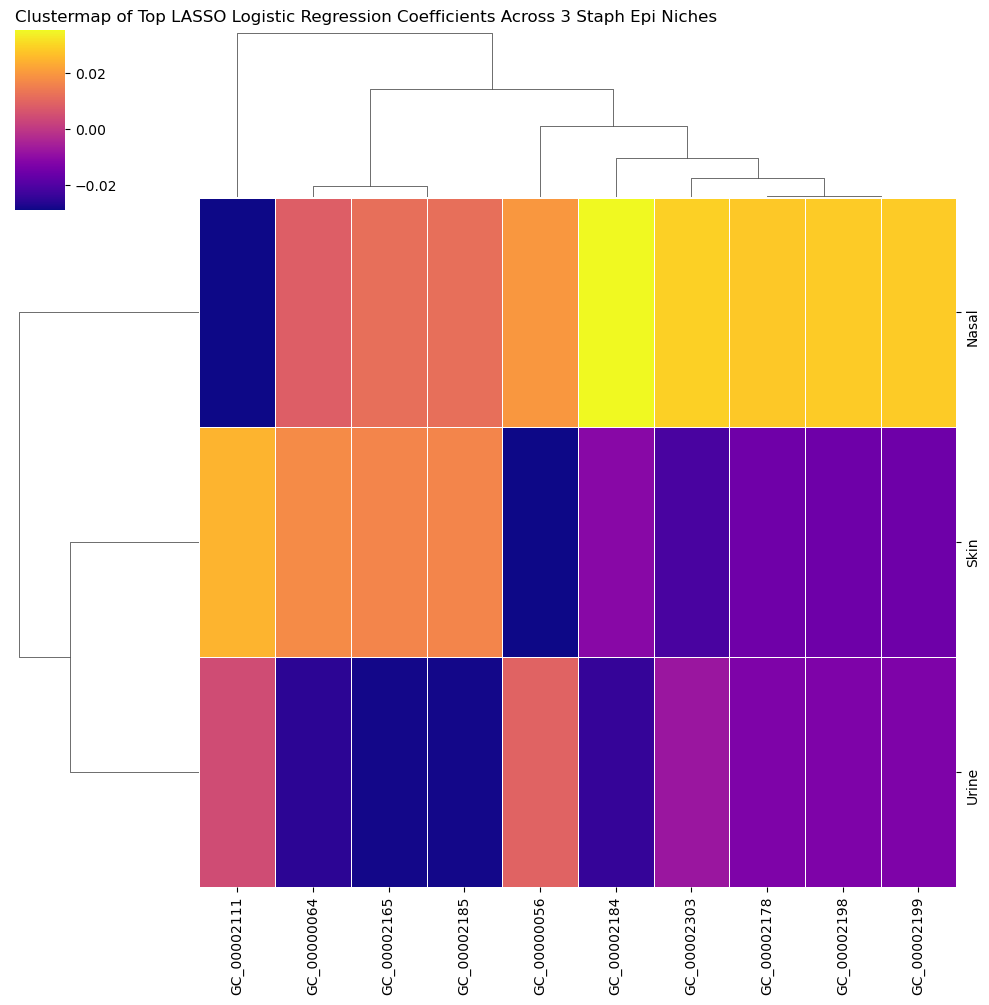

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

coef_matrix = logreg.coef_

coef_matrix_df = pd.DataFrame(coef_matrix, columns= features_filtered)

filt_coef_matrix_df = coef_matrix_df.loc[:, (abs(coef_matrix_df) > 0.025).any()] #first take the absolute value of all the values, then find the columns where in any of the four rows, there is at least one coefficient that is greater than 0.0205

index_names = ["Skin", "Urine", "Nasal"]
filt_coef_matrix_df.index = index_names

sns.clustermap(filt_coef_matrix_df, cmap = "plasma", linewidths = 0.5, xticklabels = True)
plt.title("Clustermap of Top LASSO Logistic Regression Coefficients Across 3 Staph Epi Niches", loc = "left")

filt_coef_listy = filt_coef_matrix_df.columns.to_list()
len(filt_coef_listy)

print(filt_coef_matrix_df)

In [109]:
staph_gc_summary = pd.read_csv("/Users/nirushanbhag/Downloads/sandra_ML/sandraMLfinal/staph_PG_gene_clusters_summary.txt", sep = "\t") #Load the gene cluster summary file
staph_gc_summary.head() #Display the first few rows of the gene cluster summary file

gc_in_model = staph_gc_summary[staph_gc_summary["gene_cluster_id"].isin(filt_coef_listy)] #Model with gene clusters that are in the filtered coefficient list

gc_in_model
                                                                                                                                                    

unique_id gene_cluster_id    bin_name genome_name  gene_callers_id  \
13684       13685     GC_00000056  EVERYTHING        N104             2156   
13685       13686     GC_00000056  EVERYTHING        N104             2129   
13686       13687     GC_00000056  EVERYTHING        N107             1984   
13687       13688     GC_00000056  EVERYTHING        N112             1581   
13688       13689     GC_00000056  EVERYTHING        N112             1578   
...           ...             ...         ...         ...              ...   
254743     254744     GC_00002303  EVERYTHING        S220             2205   
254744     254745     GC_00002303  EVERYTHING        U136             2131   
254745     254746     GC_00002303  EVERYTHING        U184             2099   
254746     254747     GC_00002303  EVERYTHING        U199             2189   
254747     254748     GC_00002303  EVERYTHING        U223             2000   

        num_genomes_gene_cluster_has_hits  num_genes_in_gene_cluster  \
13684                                  74                        142   
13685                                  74                        142   
13686                                  74                        142   
13687                                  74                        142   
13688                                  74                        142   
...                                   ...                        ...   
254743                                 31                         31   
254744                                 31                         31   
254745                                 31                         31   
254746                                 31                         31   
254747                                 31                         31   

        max_num_paralogs  SCG  functional_homogeneity_index  \
13684                  5    0                      0.899318   
13685                  5    0                      0.899318   
13686                  5    0                      0.899318   
13687                  5    0                      0.899318   
13688                  5    0                      0.899318   
...                  ...  ...                           ...   
254743                 1    0                      0.963489   
254744                 1    0                      0.963489   
254745                 1    0                      0.963489   
254746                 1    0                      0.963489   
254747                 1    0                      0.963489   

        geometric_homogeneity_index  combined_homogeneity_index  \
13684                      0.844194                    0.870885   
13685                      0.844194                    0.870885   
13686                      0.844194                    0.870885   
13687                      0.844194                    0.870885   
13688                      0.844194                    0.870885   
...                             ...                         ...   
254743                     0.998972                    0.980910   
254744                     0.998972                    0.980910   
254745                     0.998972                    0.980910   
254746                     0.998972                    0.980910   
254747                     0.998972                    0.980910   

       COG20_CATEGORY_ACC    COG20_CATEGORY COG20_FUNCTION_ACC  \
13684                   S  Function unknown            COG4333   
13685                   S  Function unknown            COG4333   
13686                   S  Function unknown            COG4333   
13687                   S  Function unknown            COG4333   
13688                   S  Function unknown            COG4333   
...                   ...               ...                ...   
254743                NaN               NaN                NaN   
254744                NaN               NaN                NaN   
254745                NaN               NaN       

In [110]:
gc_in_model.to_csv("/Users/nirushanbhag/Downloads/sandra_ML/sandraMLfinal/gc_in_model.csv")

In [ ]:
gc_unique_cog20_func = gc_in_model.groupby('gene_cluster_id')['COG20_FUNCTION'].nunique().reset_index() #Find unique COG20 functions per gene cluster in the model
gc_no_cog20_func = gc_unique_cog20_func[gc_unique_cog20_func['COG20_FUNCTION'] == 0]['gene_cluster_id'].to_list() #List of gene clusters with no COG20 function annotation
gc_in_model_no_cog20 = gc_in_model[gc_in_model['gene_cluster_id'].isin(gc_no_cog20_func)][['gene_cluster_id', 'aa_sequence']].drop_duplicates()#Model with gene clusters that have no COG20 function annotation

gc_in_model_no_cog20.to_csv("/Users/nirushanbhag/Downloads/sandra_ML/sandraMLfinal/gc_in_model_no_cog20_list.csv", index = True) #Export the list of gene clusters with no COG20 function annotation (dropping duplicates to avoid redundant sequences)


In [104]:
#Creating fasta file

fasta_file = open("/Users/nirushanbhag/Downloads/sandra_ML/sandraMLfinal/gc_in_model_no_cog20_sequences.faa", "w", encoding='utf-8')
for index, (header, sequence) in enumerate(zip(gc_in_model_no_cog20['gene_cluster_id'], gc_in_model_no_cog20['aa_sequence'])):
        fasta_file.write(f">{header}_{index}")
        fasta_file.write("\n")
        fasta_file.write(f"{sequence}")
        fasta_file.write("\n")

fasta_file.close()


In [105]:
cmd = f"/Users/nirushanbhag/Downloads/Software/ncbi-blast-2.13.0+/bin/blastp -query /Users/nirushanbhag/Downloads/sandra_ML/sandraMLfinal/gc_in_model_no_cog20_sequences.faa -db /Users/nirushanbhag/Downloads/swissprot/swissprot -max_target_seqs 1 -num_threads 4 -out /Users/nirushanbhag/Downloads/sandra_ML/sandraMLfinal/blast_output.csv -outfmt '10 qseqid sseqid stitle qcovs pident bitscore'"

os.system(cmd)

BLAST query error: CFastaReader: Near line 2, there's a line that doesn't look like plausible data, but it's not marked as defline or comment.


256